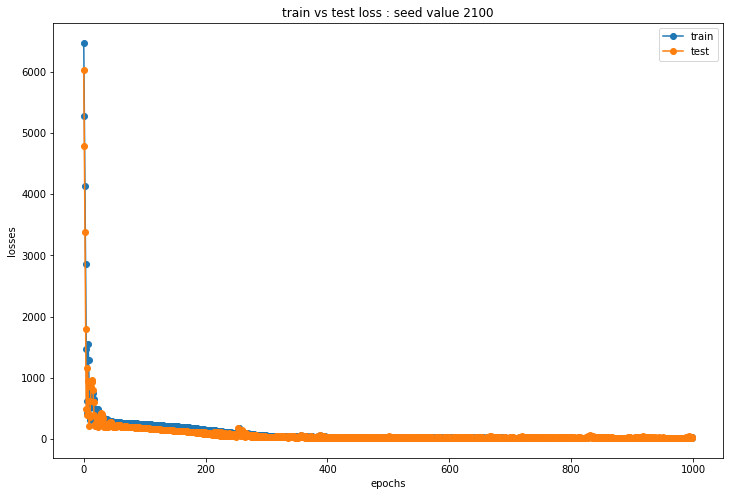

2100 5.001318757667411 4.1096590473361125


In [1]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook
import time
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler    
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
import csv
import concurrent.futures
import time
import itertools
import matplotlib.pyplot as plt



df=pd.read_csv('MLS-LA-LB-LC-LD-Real-Synthetic80svm.csv') #add (real plus synthetic) datafile name here

#separate the real and synthetic dataset
Real =df.iloc[:240, :]   # Mention the number of real samples
Synthetic =df.iloc[240:, :]




class NN(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)      
        self.regressor = nn.Sequential(
        nn.Linear(153, 33),
        nn.ReLU(),
        nn.Linear(33,150),
        nn.ReLU(),
        nn.Linear(150,400),
        nn.ReLU(),
        nn.Linear(400,168),
        nn.ReLU(),
        nn.Linear(168,128),
        nn.ReLU(),
        nn.Linear(128, 1)

        )

    def forward(self, x):
        x = self.regressor(x)
        return x


seed = 2100  # Mention seed value with best run
df1 = Real
df2 = Synthetic





exp_feat=df1.iloc[:, :-1]
exp_ee=df1.iloc[:, -1]
X_exp_train, X_test, y_exp_train, y_test = train_test_split(exp_feat, exp_ee, test_size=0.2, random_state=seed)
#print(X_test.index)
ind_test=X_test.index
df_except_test=pd.concat([X_exp_train, y_exp_train], axis=1)
df_real_syn=pd.concat([df_except_test, df2], axis=0)
#now separate train and validation set from the combined data i.e. df_real_syn
X_train_val=df_real_syn.iloc[:, :-1].values
y_train_val=df_real_syn.iloc[:, -1].values

#make all the tensors

X_train_val_tensor = torch.FloatTensor(X_train_val)
y_train_val_tensor = torch.FloatTensor(y_train_val)

X_test_tensor=torch.FloatTensor(X_test.values)
y_test_tensor=torch.FloatTensor(y_test.values)

#Instantiate the model
model=NN()
criterion=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
model.train()
epoch=1000
loss_arr=[]
loss_test_arr =[]
train_mae = []
loss_test_mae_arr=[]
y_pred_test_arr =[]
epoch_plot = []

    
def my_plot(seed_plot,epochs, train_loss, valid_loss):
    plt.figure(figsize=(12,8))
    plt.plot(train_loss,'-o')
    plt.plot(valid_loss,'-o')
    plt.xlabel('epochs')
    plt.ylabel('losses')
    plt.legend(['train','test'])
    plt.title('train vs test loss : seed value ' + str(seed_plot))
    plt.show()

for epoch in range(epoch):
    optimizer.zero_grad()
    #Forward pass
    y_pred=model(X_train_val_tensor)
    #compute loss
    loss=criterion(y_pred.squeeze(), y_train_val_tensor)

    #print(loss)
    loss_arr.append(loss.item())

    tr_mae = sum(abs(x-y) for x,y in zip(y_pred.squeeze(),y_train_val_tensor))/len(X_train_val_tensor)
    tr_mae = float(tr_mae)
    train_mae.append(tr_mae)

    #print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    epoch_plot.append(epoch)
    
    #Backward pass
    loss.backward()
    optimizer.step()
        
    with torch.no_grad():
        model.eval()
        y_pred_test=model(X_test_tensor)
        y_pred_test_arr.append(y_pred_test)
        

        loss_test=criterion(y_pred_test.squeeze(), y_test_tensor)
        loss_test_arr.append(loss_test.item())



        test_mae = sum(abs(x-y) for x,y in zip(y_pred_test.squeeze(),y_test_tensor))/len(X_test_tensor)
        test_mae = float(test_mae)
        loss_test_mae_arr.append(test_mae)
          

my_plot(seed, epoch_plot, loss_arr, loss_test_arr)


y_test_numpy = y_test_tensor.numpy()
#print(y_test_numpy)
y_pred_test_numpy = y_pred_test_arr[-1].numpy()
#print(y_pred_test_numpy)

list1= ind_test

print(seed, sqrt(loss_arr[-1]), sqrt(loss_test_arr[-1]))



In [6]:
import shap
# compute SHAP values
explainer = shap.DeepExplainer(model, X_train_val_tensor)
shap_values = explainer.shap_values(X_test_tensor)

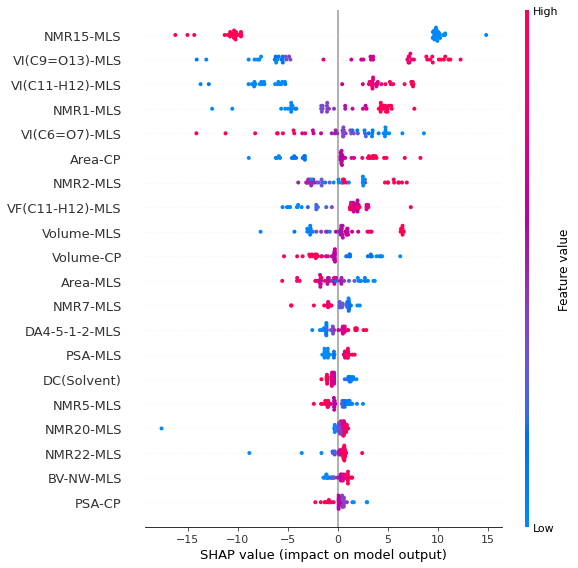

In [4]:
import matplotlib.pyplot as plt
 
shap.summary_plot(shap_values, X_test, show=False)
 
plt.savefig('shap_feature_importance_DPI300.png',format = "png",dpi = 300,bbox_inches = 'tight')

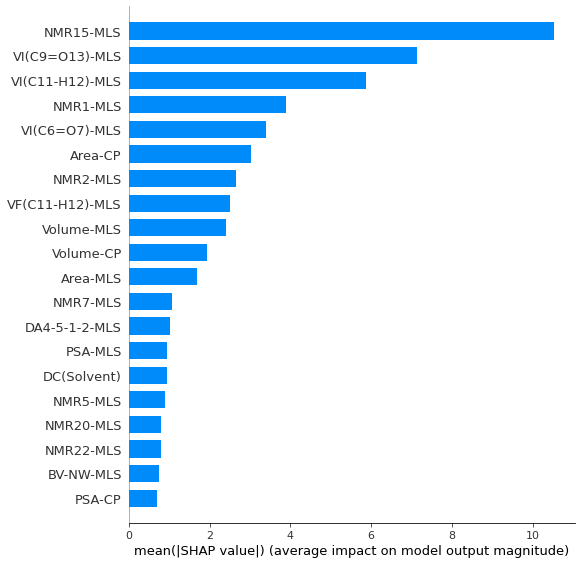

In [5]:
shap.summary_plot(shap_values, X_test, plot_type = 'bar', show = False)

plt.savefig('shap_feature_importance_bar_DPI300.png',format = "png",dpi = 300,bbox_inches = 'tight')